# (21) mnist fit — ```conv```, iter

**Motivation**: host = ```mach```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 3
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:3  ———  host: mach

In [3]:
def _eval():
    seq_total = 1 if tr.model.cfg.seq_len == 1 else 1000
    results = tr.analysis('vld', seq_total=seq_total, n_data_batches=5, verbose=False)
    
    fig, axes = plot_convergence(results, color='C0', display=False)
    fig.suptitle(name, fontsize=16, fontfamily='monospace', color='darkgreen', y=1.1)
    display(fig)

In [4]:
dataset = 'MNIST'
model_type = 'poisson'
archi_type = 'jacob|conv'

In [5]:
seq_lengths = [16]
beta_factors = [4/8, 5/8]
looper = itertools.product(
    seq_lengths,
    beta_factors,
)

name: <jacob|conv>_(16,8.0)

poisson_MNIST_t-16_z-[64]_k-32_<jacob|conv>
b200-ep400-lr(0.002)_beta(8:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_25,03:54)

epoch # 400, avg loss: 13.116721: 100%|███| 250/250 [14:49:47<00:00, 213.55s/it]


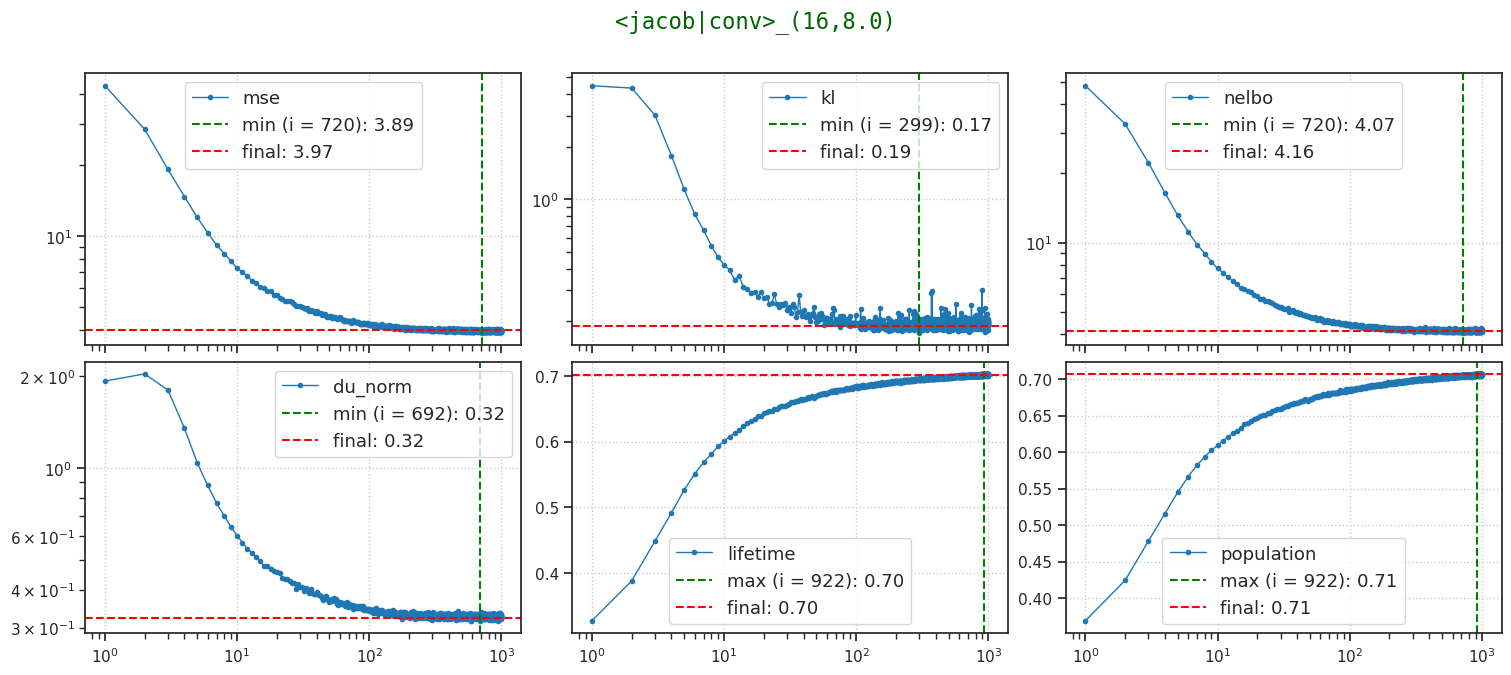

name: <jacob|conv>_(16,10.0)

poisson_MNIST_t-16_z-[64]_k-32_<jacob|conv>
b200-ep400-lr(0.002)_beta(10:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_25,18:46)

epoch # 287, avg loss: 14.729044:  72%|▋| 287/400 [14:58:12<5:43:58, 182.64s/it]

In [ ]:
%%time


for seq_len, factor in looper:
    cfg_vae, cfg_tr = default_configs(
        dataset=dataset,
        model_type=model_type,
        archi_type=archi_type,
    )
    cfg_vae['seq_len'] = seq_len
    cfg_tr['kl_beta'] = factor * seq_len

    vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
    tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

    name = f"<{archi_type}>_({tr.model.cfg.seq_len},{tr.cfg.kl_beta:0.1f})"
    print(f"name: {name}\n\n{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n\n")

    if name == '<jacob|conv>_(16,8.0)':  # continue training, coming from solo
        tr, meta = load_model(
            model_name='poisson_MNIST_t-16_z-[64]_k-32_<jacob|conv>',
            fit_name='b200-ep400-lr(0.002)_beta(8:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_24,16:22)',
            path='Dropbox/chkpts/model_hub/solo',
            device=device,
        )
        epochs = range(  # remaining epochs
            meta['checkpoint'],
            tr.cfg.epochs,
        )
        tr.train(epochs=epochs, fresh_fit=False)
    else:
        tr.train()

    _eval()

In [ ]:
print(tr.model.layer.dec)